### This is the DeepLab3+ base model


<details>
  <summary>Model Architechture</summary>
  
  - Model Definition: DeepLabV3Plus with Sigmoid and 3 input channels.
  
  - Traning Setup
        - num_epochs = 50 
        - eary stop mechanism kicks in when improvement_tolerance = 0.00001 is not satisfied.  #  Need to add to the code. 
        - learning_rate = 0.001
        - patience = 3 # number of epochs with no change before early stop
        - criterion = nn.CrossEntropyLoss()
        - optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        - scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  
  - Saver the initial state of the model before training
        - When loaded before each experiment will reset the state of the model and reinitialize optimizer and learning rate schedulers
          
  - Evaluation Metrics
        - Dice Coefficient (F1 Score)
        - Jaccard
        - Precision
        - Recall
        - Accuracy
        - Loss
</details>




In [1]:
# Installs

# !pip install torchsummary
!pip install segmentation-models-pytorch

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from PIL import Image
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize
from segmentation_models_pytorch import DeepLabV3Plus


In [3]:
#  Adding logging and saving results

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the DeepLabV3Plus model with Sigmoid for binary output
class DeepLabV3PlusWithSigmoid(nn.Module):
    def __init__(self, encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1):
        super(DeepLabV3PlusWithSigmoid, self).__init__()
        self.model = DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
model = DeepLabV3PlusWithSigmoid(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(device)

# Print model summary
# summary(model, input_size=(3, 256, 256))


DeepLabV3PlusWithSigmoid(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [4]:

# Define device and initialize DeepLabV3+ Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2)
model.to(device)

# Function to save the initial state of the model
def save_initial_model_state():
    torch.save(model.state_dict(), 'initial_deeplab_model.pth')
    print("Initial model state saved!")
# 
# Save the initial state of the model before training
save_initial_model_state()


Initial model state saved!


In [5]:

# Training setup
#num_epochs = 5  # use for testing the code.
num_epochs = 50  # normally 50 epochs
learning_rate = 0.001
improvement_tolerance = 0.0001  # Minimum improvement required to reset the counter
# improvement_tolerance = 0.00001  # Use this for the final run of the model on Google Colab ????
patience = 3 # Number of epochs to wait for improvement before early stopping
# patience = 5 # Use this for final run of the model on Google Colab ????
criterion = nn.CrossEntropyLoss()

# Initialize metric lists to store the results.
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_jaccards, test_jaccards = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_dices, test_dices = [], []

# Data transformations
def get_transforms():
    return AlbCompose([
        AlbResize(height=256, width=256, interpolation=1),  # 1 corresponds to 'bilinear'
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])


In [6]:

# Dataset Class
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        # Convert images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)  # Use the correct keyword arguments
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)  # Convert mask to binary (0 or 1)

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change shape to C x H x W
        mask = torch.tensor(mask, dtype=torch.long)  # Keep mask as long for class indices

        return image, mask

# Load datasets and define data loaders
train_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', transform=get_transforms())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', transform=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Metrics functions
def calculate_accuracy(preds, targets):
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_metrics(preds, targets):
    """Calculate Jaccard, Precision, Recall, Accuracy, and Dice Coefficient for binary classification."""
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    jaccard = jaccard_score(targets_flat, preds_flat, average='binary')
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = (preds_flat == targets_flat).sum() / len(targets_flat)

    # Dice Coefficient as F1 Score in binary case
    dice = f1_score(targets_flat, preds_flat, average='binary')

    return jaccard, precision, recall, accuracy, dice

import csv

# Function to initialize CSV with headers
def initialize_csv(filename):
    headers = [
        "Epoch", 
        "Train Loss", "Train Accuracy", "Train Jaccard", "Train Precision", "Train Recall", "Train Dice",
        "Test Loss", "Test Accuracy", "Test Jaccard", "Test Precision", "Test Recall", "Test Dice"
    ]
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)

# Function to append metrics for each epoch to CSV
def log_metrics_to_csv(filename, epoch, metrics):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch + 1,
            metrics["train_loss"], metrics["train_acc"], metrics["train_jaccard"], 
            metrics["train_precision"], metrics["train_recall"], metrics["train_dice"],
            metrics["test_loss"], metrics["test_acc"], metrics["test_jaccard"], 
            metrics["test_precision"], metrics["test_recall"], metrics["test_dice"]
        ])


In [ ]:

# Initialize CSV file before training
csv_filename = "Output/base_model_result.csv"
initialize_csv(csv_filename)

# Training function with logging to CSV
def train_and_evaluate(model, train_loader, test_loader):
    best_test_loss = float('inf')
    early_stop_counter = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        all_train_jaccard, all_train_precision, all_train_recall, all_train_dice = [], [], [], []

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += calculate_accuracy(preds, masks).item()

            # Calculate training metrics
            jaccard, precision, recall, _, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
            all_train_jaccard.append(jaccard)
            all_train_precision.append(precision)
            all_train_recall.append(recall)
            all_train_dice.append(dice)

        # Log training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)
        avg_train_jaccard = sum(all_train_jaccard) / len(all_train_jaccard)
        avg_train_precision = sum(all_train_precision) / len(all_train_precision)
        avg_train_recall = sum(all_train_recall) / len(all_train_recall)
        avg_train_dice = sum(all_train_dice) / len(all_train_dice)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        train_jaccards.append(avg_train_jaccard)
        train_precisions.append(avg_train_precision)
        train_recalls.append(avg_train_recall)
        train_dices.append(avg_train_dice)

        # Validation/Test Step
        model.eval()
        with torch.no_grad():
            running_test_loss, running_test_acc = 0.0, 0.0
            all_jaccard, all_precision, all_recall, all_accuracy, all_dice = [], [], [], [], []

            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item()

                preds = torch.argmax(outputs, dim=1)
                jaccard, precision, recall, accuracy, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
                all_jaccard.append(jaccard)
                all_precision.append(precision)
                all_recall.append(recall)
                all_accuracy.append(accuracy)
                all_dice.append(dice)

            # Average metrics
            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_acc = sum(all_accuracy) / len(all_accuracy)
            avg_jaccard = sum(all_jaccard) / len(all_jaccard)
            avg_precision = sum(all_precision) / len(all_precision)
            avg_recall = sum(all_recall) / len(all_recall)
            avg_dice = sum(all_dice) / len(all_dice)

            # Log test metrics
            test_losses.append(avg_test_loss)
            test_accuracies.append(avg_test_acc)
            test_jaccards.append(avg_jaccard)
            test_precisions.append(avg_precision)
            test_recalls.append(avg_recall)
            test_dices.append(avg_dice)

            # Print metrics after each epoch
            print(f"Epoch [{epoch + 1}/{num_epochs}]:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

            # Save metrics to CSV
            log_metrics_to_csv(csv_filename, epoch, {
                "train_loss": avg_train_loss,
                "train_acc": avg_train_acc,
                "train_jaccard": avg_train_jaccard,
                "train_precision": avg_train_precision,
                "train_recall": avg_train_recall,
                "train_dice": avg_train_dice,
                "test_loss": avg_test_loss,
                "test_acc": avg_test_acc,
                "test_jaccard": avg_jaccard,
                "test_precision": avg_precision,
                "test_recall": avg_recall,
                "test_dice": avg_dice
            })

            # Early stopping logic
            if avg_test_loss < best_test_loss - improvement_tolerance:
                best_test_loss = avg_test_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
                    break

        scheduler.step()


### Call the Train and Evaluate funciton

In [8]:
# Run the training and evaluation function
train_and_evaluate(model, train_loader, test_loader)


Epoch 1/50: 100%|██████████| 59/59 [02:40<00:00,  2.72s/it]


Epoch [1/50]:
  Train Loss: 0.1527, Train Accuracy: 0.9455
  Test Loss: 0.1117, Test Accuracy: 0.9593


Epoch 2/50: 100%|██████████| 59/59 [02:32<00:00,  2.59s/it]


Epoch [2/50]:
  Train Loss: 0.0769, Train Accuracy: 0.9721
  Test Loss: 0.0555, Test Accuracy: 0.9794


Epoch 3/50: 100%|██████████| 59/59 [02:31<00:00,  2.58s/it]


Epoch [3/50]:
  Train Loss: 0.0616, Train Accuracy: 0.9775
  Test Loss: 0.0437, Test Accuracy: 0.9852


Epoch 4/50: 100%|██████████| 59/59 [02:31<00:00,  2.57s/it]


Epoch [4/50]:
  Train Loss: 0.0624, Train Accuracy: 0.9771
  Test Loss: 0.1242, Test Accuracy: 0.9511


Epoch 5/50: 100%|██████████| 59/59 [02:32<00:00,  2.58s/it]


Epoch [5/50]:
  Train Loss: 0.0556, Train Accuracy: 0.9795
  Test Loss: 0.0511, Test Accuracy: 0.9822


Epoch 6/50: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch [6/50]:
  Train Loss: 0.0503, Train Accuracy: 0.9822
  Test Loss: 0.0558, Test Accuracy: 0.9807
Early stopping at epoch 6 due to lack of improvement.


### Plot the result metrics.

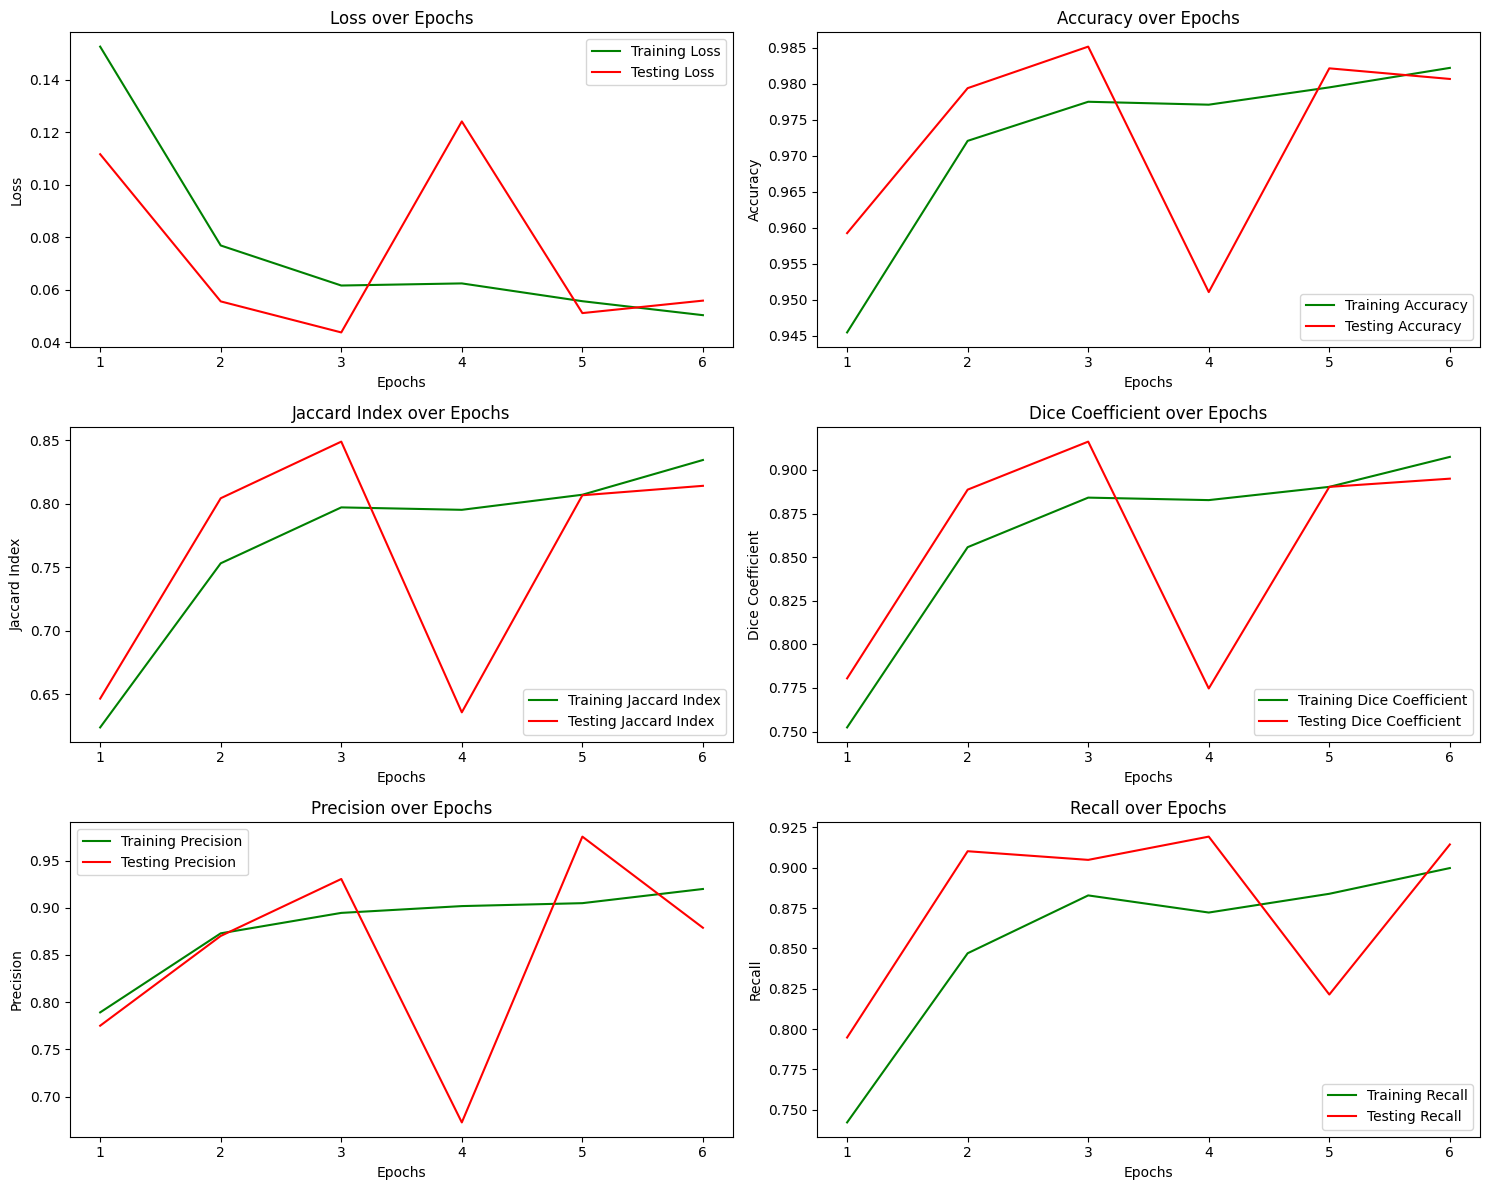

In [9]:
# New function to plot metrics after adding sigmoid to the model.

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)

    plt.figure(figsize=(15, 12))

    # Pair Loss and Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Training Loss', color='green')
    plt.plot(epochs, metrics['test_losses'], label='Testing Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Training Accuracy', color='green')
    plt.plot(epochs, metrics['test_accuracies'], label='Testing Accuracy', color='red')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Pair Jaccard Index and Dice Coefficient
    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics['train_jaccards'], label='Training Jaccard Index', color='green')
    plt.plot(epochs, metrics['test_jaccards'], label='Testing Jaccard Index', color='red')
    plt.title('Jaccard Index over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Index')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics['train_dices'], label='Training Dice Coefficient', color='green')
    plt.plot(epochs, metrics['test_dices'], label='Testing Dice Coefficient', color='red')
    plt.title('Dice Coefficient over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Pair Precision and Recall
    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics['train_precisions'], label='Training Precision', color='green')
    plt.plot(epochs, metrics['test_precisions'], label='Testing Precision', color='red')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(epochs, metrics['train_recalls'], label='Training Recall', color='green')
    plt.plot(epochs, metrics['test_recalls'], label='Testing Recall', color='red')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Collect metrics after training and pass them to the function
metrics = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'train_jaccards': train_jaccards,
    'test_jaccards': test_jaccards,
    'train_precisions': train_precisions,
    'test_precisions': test_precisions,
    'train_recalls': train_recalls,
    'test_recalls': test_recalls,
    'train_dices': train_dices,
    'test_dices': test_dices
}

# Plot metrics
plot_metrics(metrics)


### Saving the result to a csv file.

In [ ]:
import csv
import os

def save_metrics_to_csv(metrics, filename='Output/base_model_results.csv'):
    # Ensure the directory exists, create it if it doesn't
    
    # Open the CSV file for writing
    with open(filename, mode='w', newline='') as csvfile:
        fieldnames = ["Epoch", "Train Loss", "Test Loss", "Train Accuracy",
                      "Test Accuracy", "Train Jaccard", "Test Jaccard",
                      "Train Precision", "Test Precision", "Train Recall",
                      "Test Recall", "Train Dice", "Test Dice"]

        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the rows
        for epoch in range(len(metrics['train_losses'])):
            writer.writerow({
                "Epoch": epoch + 1,
                "Train Loss": metrics['train_losses'][epoch],
                "Test Loss": metrics['test_losses'][epoch],
                "Train Accuracy": metrics['train_accuracies'][epoch],
                "Test Accuracy": metrics['test_accuracies'][epoch],
                "Train Jaccard": metrics['train_jaccards'][epoch],
                "Test Jaccard": metrics['test_jaccards'][epoch],
                "Train Precision": metrics['train_precisions'][epoch],
                "Test Precision": metrics['test_precisions'][epoch],
                "Train Recall": metrics['train_recalls'][epoch],
                "Test Recall": metrics['test_recalls'][epoch],
                "Train Dice": metrics['train_dices'][epoch],
                "Test Dice": metrics['test_dices'][epoch],
            })

    print(f'Metrics saved to {filename}')


### Inspecting the results

In [ ]:
import pandas as pd

# Load the saved base model results from the CSV file.
df = pd.read_csv('Output/base_model_result.csv')

# Display the DataFrame
df


,Epoch,Train Loss,Train Accuracy,Train Jaccard,Train Precision,Train Recall,Train Dice,Test Loss,Test Accuracy,Test Jaccard,Test Precision,Test Recall,Test Dice
0,1,0.152694,0.945482,0.623690,0.789166,0.742095,0.752352,0.111662,0.959269,0.646396,0.775060,0.794728,0.780477
1,2,0.076857,0.972083,0.753066,0.872922,0.846966,0.855716,0.055530,0.979400,0.804347,0.870134,0.910217,0.888704
2,3,0.061583,0.977510,0.797135,0.894569,0.882827,0.884133,0.043693,0.985166,0.848977,0.930492,0.904859,0.916243
3,4,0.062389,0.977105,0.795219,0.901774,0.872210,0.882707,0.124166,0.951083,0.635582,0.672596,0.919272,0.774694
4,5,0.055603,0.979507,0.807116,0.904879,0.883835,0.890305,0.051070,0.982151,0.806692,0.975365,0.821378,0.890291
5,6,0.050276,0.982214,0.834491,0.919893,0.899784,0.907489,0.055822,0.980677,0.814136,0.878814,0.914410,0.895002


###  Visualize Precision of Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


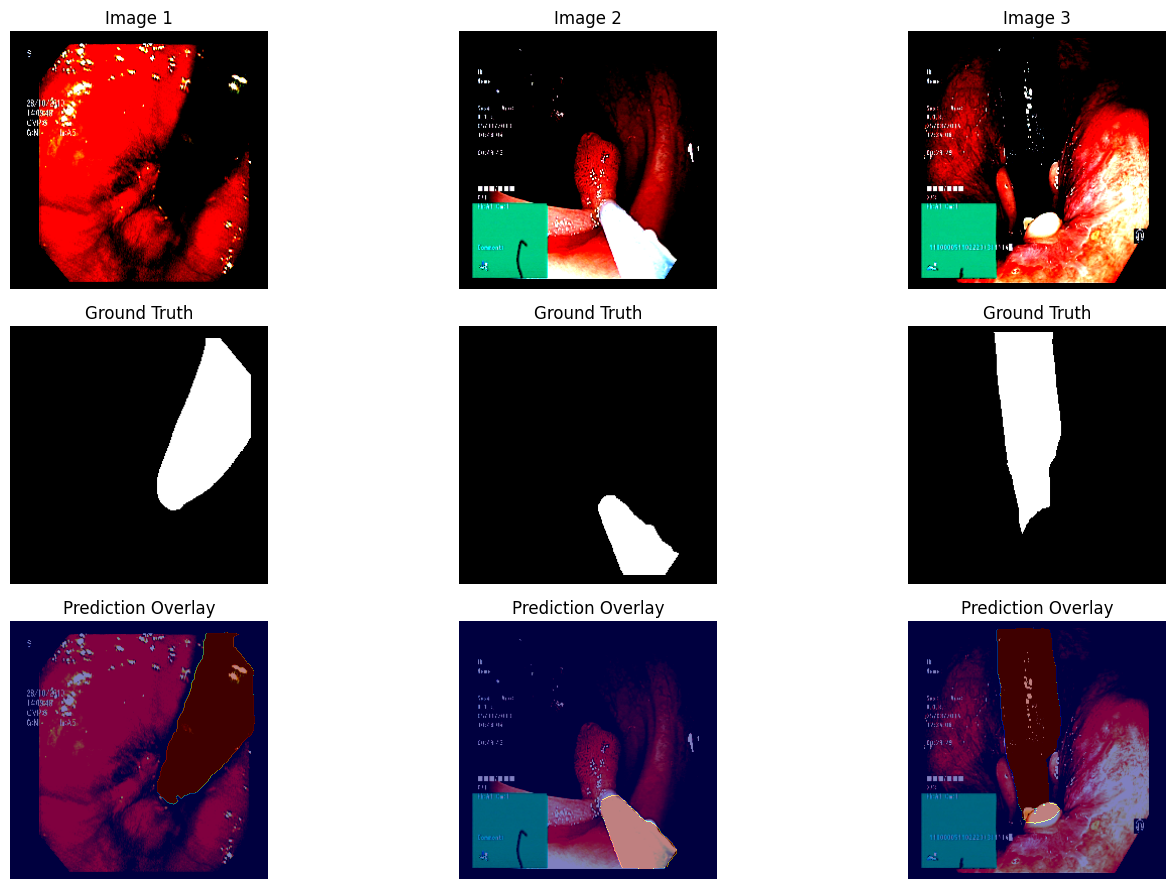

In [12]:
# Visualize Pricision

def visualize_data_with_predictions(images, masks, predictions):
    """
    Displays three rows of images:
     - Top row: Original images
     - Middle row: Ground truth masks with "Ground Truth" label
     - Bottom row: Original images with predicted masks overlaid
    """
    num_images = 3
    fig, axes = plt.subplots(3, num_images, figsize=(15, 9))

    for i in range(num_images):
        # Top row: Original images
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        # Middle row: Ground truth masks
        axes[1, i].imshow(masks[i].cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Bottom row: Original image with predicted mask overlaid
        axes[2, i].imshow(images[i])
        axes[2, i].imshow(predictions[i], alpha=0.5, cmap='jet')  # Overlay with transparency, adjust alpha for transparency.
        axes[2, i].set_title('Prediction Overlay')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()
# Get a batch of samples from the dataloader
images, masks = next(iter(test_loader))

# Move data to the device
images = images.to(device)
masks = masks.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy().astype(np.uint8)

# Convert images to NumPy arrays for visualization
images = images.cpu().permute(0, 2, 3, 1).numpy()  # Move images to CPU

# Visualize the samples with predictions
visualize_data_with_predictions(images, masks, predictions)